# Machine Learning Model for Predicting Star Properties
## Elliot Cantor

In [4]:
%env SDSS_LOCAL_SAS_MIRROR /SDSS_LOCAL_SAS_MIRROR
%env RESULTS_VERS l31c.2
%env APOGEE_APOKASC_REDUX v6.2a

env: SDSS_LOCAL_SAS_MIRROR=/SDSS_LOCAL_SAS_MIRROR
env: RESULTS_VERS=l31c.2
env: APOGEE_APOKASC_REDUX=v6.2a


In [8]:
import os, sys, math, gc
from collections import Counter
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline
import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io.votable import parse
from astroquery.utils.tap.core import TapPlus
from astropy.stats import LombScargle
from astropy.io import fits
import emcee
import corner
from scipy.optimize import minimize
import urllib
from apogee.spec import continuum as cont
#import mpld3
#mpld3.enable_notebook()

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]

import warnings
warnings.filterwarnings('ignore')

#Constants in MKS
mSun     = 1.989 * (10**30)      #sun mass
mJup     = 1.898 * (10**27)      #jupiter mass
mEarth   = 5.972 * (10**24)      #earth mass
rSun     = 695.508 * (10**6)     #sun radius
rJup     = 69.911 * (10**6)      #jupiter radius
rEarth   = 6378000               #earth radius
rNep     = (49528 / 2) * (10**3) #neptune radius
AU       = 1.496 * (10**11)      #au
G        = 6.67 * 10**(-11)      #gravitational constant
SB       = 5.67 * (10**-8)       #stephen-boltzman constant
insEarth = 1362                  #insolation flux of earth

rnd        = np.random.RandomState(42)

In [9]:
loc_ids = [4230, 4262, 5162, 4241]

In [ ]:
sizes   = []

for ID in loc_ids:
    path = str(ID)
    os.mkdir(path)
    os.chdir(path)
    urlpath = urllib.request.urlopen(f'https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/{ID}/')
    dirty = urlpath.read().decode('utf-8')
    stringends = dirty.split('>')
    ends = [end[:-3] for end in stringends if (end[0:9] == 'apStar-r8') and (len(end) < 42)]
    sizes.append(len(ends))
    for end in ends:
        urllib.request.urlretrieve(f'https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/{ID}/{end}', f'{end}')
    os.chdir('..')

In [11]:
print(f'The total number of fits files is: {sum([len(os.listdir(str(id))) for id in loc_ids])}')

The total number of fits files is: 2721


In [12]:
fit = fits.open('4230/apStar-r8-2M21233217+1211528.fits')

In [15]:
wavelengths = []
log_start = 4.179
log_disp  = 6e-6
for i in range(len(fit[1].data[0])):
    wavelengths.append(log_start + (log_disp * i))

wavelengths = 10 ** np.asarray(wavelengths)
print(f'The wavelengths go from {wavelengths.min()} Angstroms to {wavelengths.max()} Angstroms.')

The wavelengths go from 15100.801541641493 Angstroms to 16999.807358923248 Angstroms.


In [17]:
### Matching all of the data

obj_ids = []
teff    = []
eteff   = []
logg    = []
elogg   = []
FeH     = []
eFeH    = []
MgFe    = []
eMgFe   = []
SiFe    = []
eSiFe   = []
snr     = []

### Gathering labels for the spectra

for j in range(len(loc_ids)):
    for i in range(len(os.listdir(f'{loc_ids[j]}'))):
        strstart = f'apogee.apo25m.s.stars.{loc_ids[j]}.'
        strend   = os.listdir(f'{loc_ids[j]}')[i][10:-5]
        obj_ids.append(strend)
        ind = np.where(strstart + strend == fit[1].data['APSTAR_ID'])[0][0] 
        if fit[1].data['LOCATION_ID'][ind] != loc_ids[j]:
            print('This location ID is wrong:', ind)
        teff.append(fit[1].data['TEFF'][ind])
        eteff.append(fit[1].data['TEFF_ERR'][ind])
        logg.append(fit[1].data['LOGG'][ind]) 
        elogg.append(fit[1].data['LOGG_ERR'][ind])
        FeH.append(fit[1].data['FE_H'][ind])  
        eFeH.append(fit[1].data['FE_H_ERR'][ind]) 
        MgFe.append(fit[1].data['MG_FE'][ind])
        eMgFe.append(fit[1].data['MG_FE_ERR'][ind])
        SiFe.append(fit[1].data['SI_FE'][ind]) 
        eSiFe.append(fit[1].data['SI_FE_ERR'][ind])
        snr.append(fit[1].data['SNR'][ind])

In [18]:
### Turning it all into a Pandas DataFrame
d = {
     'OBJECT_ID': obj_ids,
     'TEFF' : teff, 'TEFF_ERR' : eteff, 
     'LOGG' : logg, 'LOGG_ERR' : elogg, 
     'FE_H' : FeH , 'FE_H_ERR' : eFeH ,
     'MG_FE': MgFe, 'MG_FE_ERR': eMgFe,
     'SI_FE': SiFe, 'SI_FE_ERR': eSiFe,
     'SNR'  : snr
    }

df_raw = pd.DataFrame(d)
#df_raw = df_raw.set_index('OBJECT_ID')
df_raw.head()

,OBJECT_ID,TEFF,TEFF_ERR,LOGG,LOGG_ERR,FE_H,FE_H_ERR,MG_FE,MG_FE_ERR,SI_FE,SI_FE_ERR,SNR
0,2M21302278+1121415,5153.868164,107.863983,2.355246,0.065976,-0.678669,0.010074,0.171006,0.030287,0.190341,0.040434,106.962997
1,2M21271836+1058236,5234.882324,99.561188,3.470621,0.062127,-0.165351,0.007606,0.031832,0.018628,0.029333,0.030363,179.376007
2,2M21305280+1216411,4972.930664,114.182571,-9999.000000,-9999.000000,-0.021140,0.014120,0.137995,0.037470,0.080929,0.038656,82.053398
3,2M21243358+1228505,4776.683105,74.713554,2.868354,0.062768,-0.405365,0.009209,0.302043,0.022493,0.192283,0.029080,351.145996
4,2M21325045+1206334,3632.635010,77.442772,-9999.000000,-9999.000000,-0.608415,0.013033,0.162420,0.036664,0.103116,0.031478,533.166992


In [19]:
print(f'There are currently {len(df_raw)} spectra in my raw data frame.')

There are currently 2721 spectra in my raw data frame.


In [20]:
### Applying Quality Cuts

df = df_raw.loc[
                (df_raw['TEFF']  > 0)  &
                (df_raw['LOGG']  > 0)  &  
                (df_raw['FE_H']  > -1) &
                (df_raw['SNR']   > 50) &
                (df_raw['SI_FE'] > -9) &
                (df_raw['MG_FE'] > -9)
               ]

df.head()

,OBJECT_ID,TEFF,TEFF_ERR,LOGG,LOGG_ERR,FE_H,FE_H_ERR,MG_FE,MG_FE_ERR,SI_FE,SI_FE_ERR,SNR
0,2M21302278+1121415,5153.868164,107.863983,2.355246,0.065976,-0.678669,0.010074,0.171006,0.030287,0.190341,0.040434,106.962997
1,2M21271836+1058236,5234.882324,99.561188,3.470621,0.062127,-0.165351,0.007606,0.031832,0.018628,0.029333,0.030363,179.376007
3,2M21243358+1228505,4776.683105,74.713554,2.868354,0.062768,-0.405365,0.009209,0.302043,0.022493,0.192283,0.029080,351.145996
12,2M21320875+1218263,4918.193359,96.953285,2.761881,0.052997,-0.325925,0.009112,0.031703,0.025470,-0.335099,0.033109,69.556297
19,2M21295621+1315323,4851.495605,101.497650,2.376463,0.055151,-0.354752,0.009798,0.312556,0.029597,0.200890,0.035598,97.060600


In [21]:
print(f'There are {len(df)} spectra left in my data frame after my quality cuts.')

There are 1712 spectra left in my data frame after my quality cuts.


In [42]:
### Checking for bad files

strstart = 'apStar-r8-'
for j in range(len(loc_ids)):
    for i in range(len(os.listdir(f'{loc_ids[j]}'))):
        fits_dir = f'{loc_ids[j]}/{os.listdir(str(loc_ids[j]))[i]}'
        spectra.append(get_single_fits_data(fits_dir)) 
        try:
            if len(get_single_fits_data(fits_dir)) != 8575:
                print(i, 'Bad spectrum')
        except:
            print(fits_dir)

In [44]:
### Dropping a couple messed up spectra without any data

drop_list = [] 

for i in df.index.values:
    if type(df['ERR_SPEC'].loc[i]) == int:
        drop_list.append(i)
        
df.drop(drop_list, inplace=True)

In [45]:
### Changing the errors for all bad pixels to 10^20 for every error array in my dataframe  

for i in range(len(df)):
    bitmasks    = df['BITMASK'].iloc[i]
    err_spectra = df['ERR_SPEC'].iloc[i]
    bad_pixels  = (bitmasks & 4351) != 0
    ind         = np.where(bad_pixels == True)[0]
    if len(ind) > 0:
        df['ERR_SPEC'].iloc[i][ind] = 10**20
    else:
        continue

In [22]:
def mean_normalization(label):
    data = df[label].values
    normal = []
    for i in range(len(data)):
        normed = (data[i] - np.average(data)) / (np.max(data) - np.min(data))
        normal.append(normed)
    return np.array(normal)

def min_normalization(label):
    data = df[label].values
    normal = []
    for i in range(len(data)):
        normed = (data[i] - np.min(data)) / (np.max(data) - np.min(data))
        normal.append(normed)
    return np.array(normal)   

In [23]:
### Before I sperate the arrays I'm making new columns for the power transformed flux errors and feature scaled labels

from sklearn import preprocessing
pt = preprocessing.PowerTransformer()

def power_transform(column_name):
    return pt.fit_transform(df[column_name].values.reshape(-1,1)).reshape(-1)

df['PT_ERR_SPEC']  = 0
df['PT_ERR_SPEC']  = df['PT_ERR_SPEC'].astype(np.ndarray)
for i in df.index.values:
    new_err = pt.fit_transform(df['ERR_SPEC'].loc[i].reshape(-1,1)).reshape(-1)
    df.at[i, 'PT_ERR_SPEC'] = new_err

df['N_TEFF']      = mean_normalization('TEFF')
df['N_TEFF_ERR']  = mean_normalization('TEFF_ERR')
df['N_LOGG']      = mean_normalization('LOGG')
df['N_LOGG_ERR']  = mean_normalization('LOGG_ERR')
df['N_FE_H']      = mean_normalization('FE_H')
df['N_FE_H_ERR']  = mean_normalization('FE_H_ERR')
df['N_MG_FE']     = mean_normalization('MG_FE')
df['N_MG_FE_ERR'] = mean_normalization('MG_FE_ERR')
df['N_SI_FE']     = mean_normalization('SI_FE')
df['N_SI_FE_ERR'] = mean_normalization('SI_FE_ERR')

df['M_TEFF']      = min_normalization('TEFF')
df['M_LOGG']      = min_normalization('LOGG')
df['M_FE_H']      = min_normalization('FE_H')
df['M_MG_FE']     = min_normalization('MG_FE')
df['M_SI_FE']     = min_normalization('SI_FE')


In [27]:
# Shuffling the dataframe rows and splitting it in two halfs

df = df.sample(frac=1)
boundary = int(0.5 * len(df))

df_train     = df.iloc[:boundary]
df_cross_val = df.iloc[boundary:]

In [54]:
df_train.head()

,OBJECT_ID,TEFF,TEFF_ERR,LOGG,LOGG_ERR,FE_H,FE_H_ERR,MG_FE,MG_FE_ERR,SI_FE,...,N_FE_H_ERR,N_MG_FE,N_MG_FE_ERR,N_SI_FE,N_SI_FE_ERR,M_TEFF,M_LOGG,M_FE_H,M_MG_FE,M_SI_FE
2537,2M19433551+2440052,4482.852539,70.953270,2.070187,0.057238,0.126549,0.008120,-0.033025,0.019061,-0.018739,...,-0.039048,-0.159537,-0.034572,-0.056814,-0.057142,0.466620,0.546149,0.728711,0.295234,0.522154
2012,2M19435609+2319117,4940.999023,93.608543,2.628898,0.046750,0.031466,0.007789,0.000413,0.019616,0.008889,...,-0.084596,-0.108716,-0.014925,-0.024467,0.087048,0.703804,0.698055,0.665798,0.346054,0.554501
532,2M21245990+1254106,4561.697266,66.056015,2.375340,0.059504,-0.320159,0.009217,0.257227,0.021680,0.099944,...,0.112171,0.281610,0.058204,0.082142,0.028780,0.507438,0.629116,0.433139,0.736380,0.661109
725,2M21280856+1313228,4565.171875,80.824959,2.850636,0.055619,0.470978,0.007070,0.112535,0.016578,-0.058442,...,-0.183787,0.061696,-0.122510,-0.103300,-0.099452,0.509237,0.758342,0.956609,0.516466,0.475668
2305,2M19494472+2345156,5071.486328,103.745430,2.792584,0.048914,0.131809,0.007391,-0.084066,0.018896,-0.077001,...,-0.139527,-0.237114,-0.040427,-0.125028,0.106690,0.771358,0.742559,0.732192,0.217657,0.453940


# Neural Network Creation Begins Below


First I am shortening the individual spectrums by cutting out all indicies that have zeros in them in order to allow the neural network to avoid focusing on them due to the lack of flux errors being used in my network. 
I am also renormalizing my labels to unity through min-max feature scaling in order to take advantage of the sigmoid activation in keras which only outputs to [0,1].

The indices (they are the same for every spectrum due to band pass gaps) that I'm cutting out are:

boundary0 = 0:245

boundary1 = 3274:3584

boundary2 = 6080:6343

boundary3 = 8335:8574

In [21]:
good_ind = np.where(df_train['NORM_SPEC'].iloc[0] != 0)[0]
normalized_fluxes = df_train['NORM_SPEC'].values
flux_train = np.array([fluxes[good_ind] for fluxes in normalized_fluxes])

normalized_fluxes = df_cross_val['NORM_SPEC'].values
flux_cross_val = np.array([fluxes[good_ind] for fluxes in normalized_fluxes])

In [7]:
from keras.utils import to_categorical
from keras import models
from keras.layers import Dense, Activation, LSTM, Dropout
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential  # linear stack of layers
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical
from keras import models
from keras import layers

Using TensorFlow backend.


In [8]:
np.random.RandomState(7)

In [44]:
train_X = flux_train
train_y = df_train[['M_TEFF', 'M_LOGG', 'M_FE_H', 'M_MG_FE', 'M_SI_FE']].values
test_X  = flux_cross_val
test_y  = df_cross_val[['M_TEFF', 'M_LOGG', 'M_FE_H', 'M_MG_FE', 'M_SI_FE']].values

print(train_X.shape, '\n', train_y.shape)

(856, 7514) 
 (856, 5)


In [13]:
keras.backend.clear_session()

In [14]:
#Initializing Neural Network
classifier = Sequential()
classifier.reset_states()

# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 300, init = 'uniform', activation = 'relu', input_dim = 7514))

# Adding the second hidden layer
classifier.add(Dense(output_dim = 150, init = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(output_dim = 5, init = 'uniform', activation = 'sigmoid'))

# Compiling Neural Network
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'mse'])

# Fitting our model
result = classifier.fit(train_X, train_y, batch_size=10, nb_epoch=100)


Epoch 1/100
856/856 [==============================] - 5s 5ms/step - loss: 4.4239 - acc: 0.5876 - mean_squared_error: 0.0487
Epoch 2/100
856/856 [==============================] - 4s 5ms/step - loss: 4.4204 - acc: 0.5958 - mean_squared_error: 0.0442
Epoch 3/100
856/856 [==============================] - 5s 6ms/step - loss: 4.4183 - acc: 0.6133 - mean_squared_error: 0.0408
Epoch 4/100
856/856 [==============================] - 4s 4ms/step - loss: 4.4191 - acc: 0.6145 - mean_squared_error: 0.0386
Epoch 5/100
856/856 [==============================] - 4s 5ms/step - loss: 4.4155 - acc: 0.6227 - mean_squared_error: 0.0372
Epoch 6/100
856/856 [==============================] - 4s 5ms/step - loss: 4.4137 - acc: 0.6227 - mean_squared_error: 0.0245
Epoch 7/100
856/856 [==============================] - 4s 4ms/step - loss: 4.4116 - acc: 0.6180 - mean_squared_error: 0.0265
Epoch 8/100
856/856 [==============================] - 4s 5ms/step - loss: 4.4143 - acc: 0.6215 - mean_squared_error: 0.0263


856/856 [==============================] - 3s 3ms/step - loss: 4.3939 - acc: 0.6951 - mean_squared_error: 0.0116
Epoch 67/100
856/856 [==============================] - 2s 3ms/step - loss: 4.3910 - acc: 0.7033 - mean_squared_error: 0.0111
Epoch 68/100
856/856 [==============================] - 2s 3ms/step - loss: 4.3922 - acc: 0.6963 - mean_squared_error: 0.0112
Epoch 69/100
856/856 [==============================] - 2s 3ms/step - loss: 4.3887 - acc: 0.7185 - mean_squared_error: 0.0101
Epoch 70/100
856/856 [==============================] - 3s 3ms/step - loss: 4.3892 - acc: 0.7150 - mean_squared_error: 0.0100
Epoch 71/100
856/856 [==============================] - 3s 4ms/step - loss: 4.3897 - acc: 0.7056 - mean_squared_error: 0.0099
Epoch 72/100
856/856 [==============================] - 4s 5ms/step - loss: 4.3902 - acc: 0.6998 - mean_squared_error: 0.0099
Epoch 73/100
856/856 [==============================] - 5s 6ms/step - loss: 4.3911 - acc: 0.7126 - mean_squared_error: 0.0109
Epoch

In [15]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               2254500   
_________________________________________________________________
dense_2 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 755       
Total params: 2,300,405
Trainable params: 2,300,405
Non-trainable params: 0
_________________________________________________________________


In [118]:
prediction = classifier.predict(test_X).T
#np.save('machine_data', prediction)

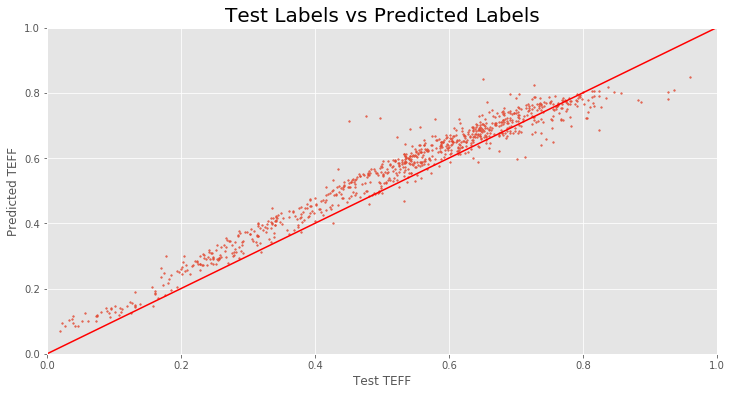

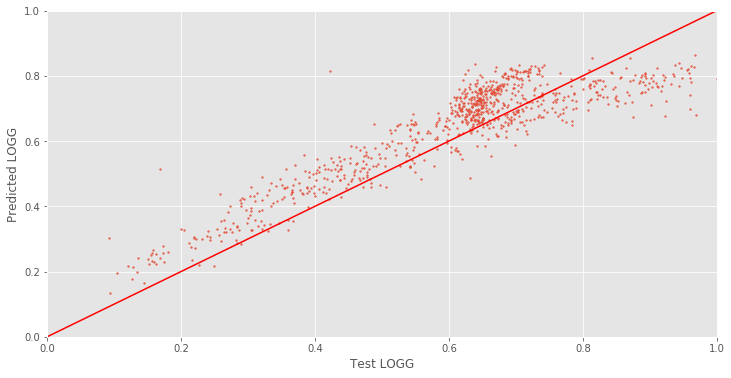

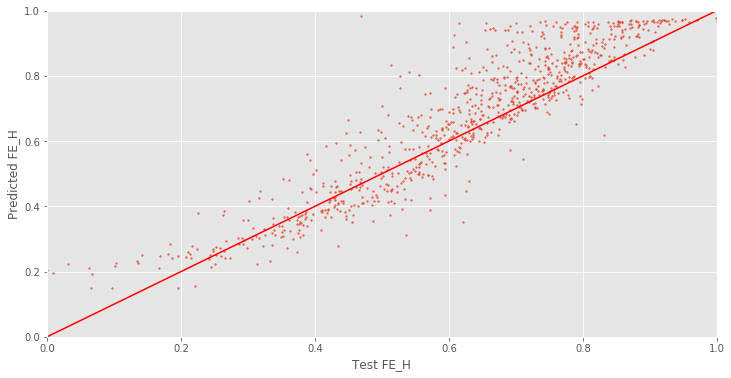

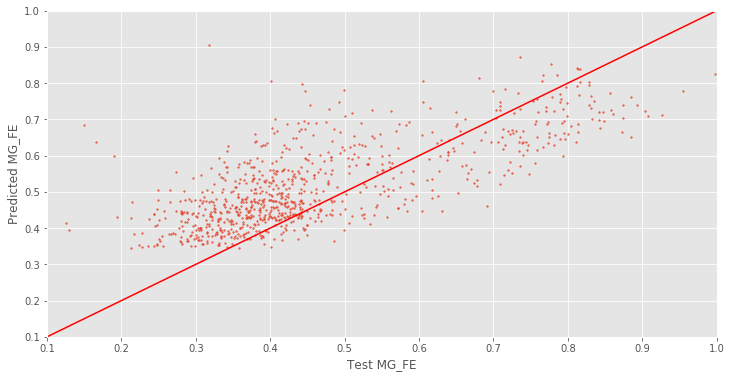

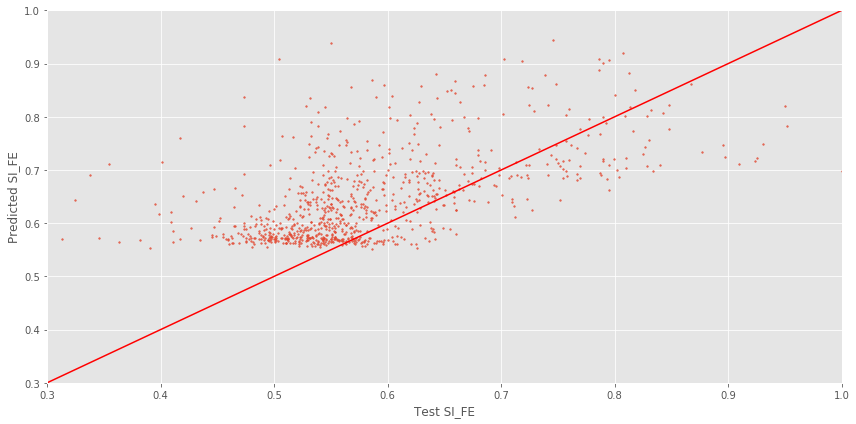

In [114]:
labels = ['TEFF', "LOGG", "FE_H", "MG_FE", "SI_FE"]
xlims = [(0, 1), (0, 1), (0, 1), (0.1,1), (0.3, 1)]
ylims = [(0, 1), (0, 1), (0, 1), (0.1, 1), (0.3, 1)]
for i in range(len(test_y.T)):
    plt.figure()
    plt.scatter(test_y.T[i], classifier.predict(test_X).T[i],alpha=0.8,s=3)
    plt.plot([0.0, 1.0], [0.0,1.0], c='r')
    plt.xlim(xlims[i])
    plt.ylim(ylims[i])
    plt.xlabel(f"Test {labels[i]}")
    plt.ylabel(f"Predicted {labels[i]}")
    if i == 0:
        plt.title('Test Labels vs Predicted Labels', fontsize=20)
plt.tight_layout();

In [117]:
units  = ['K', ' ', 'dex', 'dex', 'dex']
for i in range(len(labels)):
    print(f"""The median absolute residual from my neural network compared to the \n allStar values for {labels[i]} is {round(np.median(np.abs(un_min_normalize(labels[i], test_y.T[i]) - un_min_normalize(labels[i], prediction[i]))), 3)} {units[i]}""")

The median absolute residual from my neural network compared to the 
 allStar values for TEFF is 82.556 K
The median absolute residual from my neural network compared to the 
 allStar values for LOGG is 0.264  
The median absolute residual from my neural network compared to the 
 allStar values for FE_H is 0.08 dex
The median absolute residual from my neural network compared to the 
 allStar values for MG_FE is 0.057 dex
The median absolute residual from my neural network compared to the 
 allStar values for SI_FE is 0.057 dex
